# Imports

Steps to improve model:
1. Knowing this in Russia, add the bank and the school holidays
2. Add features that display the summer season, christmas and other important holidays or peak seasons in russia
3. check whether some items wherein specific discount and check sales relevant to them
4. Are same products sold for different prices in different stores
5. Price fluctuations over this period, does this affect the prcie?
6. How about stores that have closed, example shop 23
7. #### Check whether some data can point to a sales/marketing campaign, and add it as a feature then add days of saledate-campaign date as a new feature

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from itertools import product

In [3]:
pd.options.display.float_format = '{:,.0f}'.format

In [4]:
train = pd.read_csv('Data/Grocery/sales_train.csv.gz')
shops = pd.read_csv('Data/Grocery/shops.csv')
items = pd.read_csv('Data/Grocery/items.csv')
test = pd.read_csv('Data/Grocery/test.csv.gz')
items_cats = pd.read_csv('Data/Grocery/item_categories.csv')
sub = pd.read_csv('Data/Grocery/sample_submission.csv.gz')

In [85]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [86]:
trn = train.copy()

In [87]:
trn.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [88]:
trn.shape

(2935849, 6)

In [97]:
trn.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999,1
1,03.01.2013,0,25,2552,899,1
2,05.01.2013,0,25,2552,899,-1
3,06.01.2013,0,25,2554,"1,709",1
4,15.01.2013,0,25,2555,"1,099",1


# Preprocessing data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level

In [168]:
# extract all unique item ids every month in a list
grid = []
for month in trn.date_block_num.unique():
    item_list = trn[trn.date_block_num == month].item_id.unique()
    shop_list = trn[trn.date_block_num == month].shop_id.unique()
    grid.append(np.array(list(product(*[[month], shop_list, item_list])))) # Use product to get month, shop, item cartesian combination

In [169]:
grid = pd.DataFrame(np.vstack(grid), columns=['date_block_num', 'shop_id', 'item_id'])

#### Adding the total amount of items sold per store month

In [170]:
temp = trn.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day']].sum()
temp.rename(columns={'item_cnt_day':'Target'}, inplace=True)

In [171]:
all_data = grid.merge(temp, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

#### Add the mean of items sold per store per month

In [172]:
temp_mean = trn.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day']].mean()
temp_mean.rename(columns={'item_cnt_day':'Target_mean'}, inplace=True)

In [173]:
all_data = all_data.merge(temp_mean, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

In [174]:
all_data.sort_values(['date_block_num', 'shop_id', 'item_id'], inplace=True)

In [176]:
all_data.reset_index(drop=True, inplace=True)

#### Add the number of items sold by store for the previous month

In [212]:
tests = all_data.copy()

In [235]:
x = tests[tests['date_block_num']==33][['shop_id','item_id','Target']]
x = x.rename(columns={'Target':'target_prev'})

In [223]:
y = pd.merge(tests, x, how='left', on=['shop_id','item_id']).fillna(0.)

In [247]:
x.target_prev.sum()

71056.0

In [250]:
y[:238172].target_prev.sum()

7302.0

In [178]:
all_data.tail()

,date_block_num,shop_id,item_id,Target,Target_mean
10913845,33,59,22162,0,0
10913846,33,59,22163,0,0
10913847,33,59,22164,0,0
10913848,33,59,22166,0,0
10913849,33,59,22167,0,0


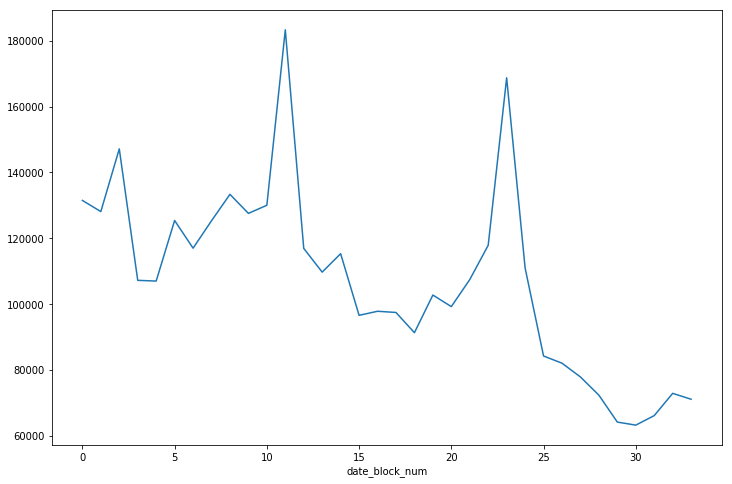

In [153]:
all_data.groupby('date_block_num')['Target'].sum().plot(figsize=(12,8))

In [19]:
# date_att = ['day','dayofweek','dayofyear','days_in_month','is_month_end','is_month_start','is_quarter_end','is_quarter_start','is_year_end',
#  'is_year_start','month','quarter','week','weekday','weekofyear','year']

# for i in date_att:
#     df_train['sale_'+i] = getattr(df_train['date'].dt, i)
# df_train.drop('date', axis = 1, inplace=True)

In [27]:
# def print_score(m):
#     res = [rmse(m.predict(X_train), y_train) , rmse(m.predict(X_valid), y_valid),
#             m.score(X_train, y_train), m.score(X_valid, y_valid)]
#     print(res)

In [154]:
# m = RandomForestRegressor(n_jobs=-1)
# m.fit(X_train, y_train)
# print_score(m)